## Spark cluster intro Air quality examples

### Initialization
Create and attach cluster created in EMR. 

The important configuration options:
 - Amazon EMR version: emr-7.1.0
 - Installed applications: JupyterHub 1.5.0
 - Logs in Amazon S3: disabled
 - Service role for Amazon EMR: EMR_DefaultRole 
 - EC2 instance profile: EMR_EC2_DefaultRole
 - EC2 security groups (firewall): open ports 9443, 18080
 
Login: jovyan, password: jupyter

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
spark = SparkSession.builder.getOrCreate()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1731841293982_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1731841293982_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1731841293982_0003,pyspark,idle,Link,Link,None,✔


In [3]:
# run once per session to install additional packages
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1731841293982_0003/container_1731841293982_0003_01_000001/tmp/spark-a6aa8d59-1a96-4735-a6fa-bf7bddf093d3
    Can't uninstall 'python-dateutil'. No files were found to uninstall.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.15.30 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.


In [4]:
from pyspark.sql.functions import col, mean
import matplotlib.pyplot as plt
import pandas as pd
import time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Reading data from AWS S3

Now we can read a small sample of data:

In [5]:
start = time.time()

smog_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load("s3a://openaq-data-archive/records/csv.gz/locationid=10*/year=2022/month=05/*.csv.gz")
    #.load("s3a://openaq-data-archive/records/csv.gz/locationid=2178/year=2022/month=05/location-2178-20220503.csv.gz")\

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

222.49383854866028

In [6]:
# Further queries on smog_df will run much faster when we cache this data set in memory
smog_df.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[location_id: string, sensors_id: string, location: string, datetime: string, lat: string, lon: string, parameter: string, units: string, value: string]

In [7]:
start = time.time()
smog_df.count()
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

104.60621762275696

In [8]:
smog_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location_id: string (nullable = true)
 |-- sensors_id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: string (nullable = true)

In [9]:
smog_df = smog_df.withColumn("value", smog_df.value.cast('double'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Simple queries

In [10]:
smog_df.limit(10).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+--------------------+--------------------+---------+---------+---------+-----+-------+
|location_id|sensors_id|            location|            datetime|      lat|      lon|parameter|units|  value|
+-----------+----------+--------------------+--------------------+---------+---------+---------+-----+-------+
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T01:00:...|50.349608|18.236575|     pm10|µg/m³|  15.62|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T02:00:...|50.349608|18.236575|     pm10|µg/m³|13.6041|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T03:00:...|50.349608|18.236575|     pm10|µg/m³|13.7349|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T04:00:...|50.349608|18.236575|     pm10|µg/m³|15.1872|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T05:00:...|50.349608|18.236575|     pm10|µg/m³|13.0822|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T06:00:...|50.349608|18.236575|     pm10|µg/m³|14.0526|
|

In [11]:
smog_df.select('parameter').distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|parameter|
+---------+
|       co|
|     pm10|
|      so2|
|      no2|
|       bc|
|     pm25|
|       o3|
+---------+

In [12]:
from pyspark.sql.functions import col, asc, desc, max

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Some more interesting statistics

In [13]:
start = time.time()
max_pm10 = smog_df.filter(col('parameter')=='pm10')\
            .filter(col('value')>0.0)\
            .groupby('location').agg(max('value').alias('max_pm10'))\
            .sort(desc('max_pm10'))

max_pm10.limit(100).show(truncate=False)
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------------+-----------+
|location                                        |max_pm10   |
+------------------------------------------------+-----------+
|Ballygunge, Kolkata - WBPCB-10918               |9999.9     |
|Govt. High School Shikarpur, Patna - BSPCB-10630|5631.1     |
|Sanjay Nagar, Ghaziabad - UPPCB-10919           |3490.0     |
|New Industrial Town, Faridabad - HSPCB-10920    |2217.0     |
|Mundka, Delhi - DPCC-10486                      |1787.0     |
|Sector 30, Faridabad - HSPCB-10820              |1309.16    |
|Nedre Langgate-10492                            |1187.386375|
|Mini Secretariat, Charkhi Dadri - HSPCB-10725   |1186.4     |
|Sector 11, Faridabad - HSPCB-10908              |1090.9     |
|Rajbansi Nagar, Patna - BSPCB-10599             |1003.2     |
|Sector-51, Gurugram - HSPCB-10825               |999.99     |
|Rishi Nagar, Kaithal - HSPCB-10905              |999.99     |
|Murthal, Sonipat - HSPCB-10906                  |999.9

In [14]:
smog_df.filter(col('location').contains('Krak')).select('location').distinct().show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------+
|location                        |
+--------------------------------+
|Kraków, ul. Bulwarowa-10516     |
|Kraków, Aleja Krasińskiego-10752|
+--------------------------------+

In [15]:
max_pm10.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location: string (nullable = true)
 |-- max_pm10: double (nullable = true)

In [16]:
plt.figure()
max_pm10.limit(10).toPandas().plot.barh(x='location')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<Axes: ylabel='location'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

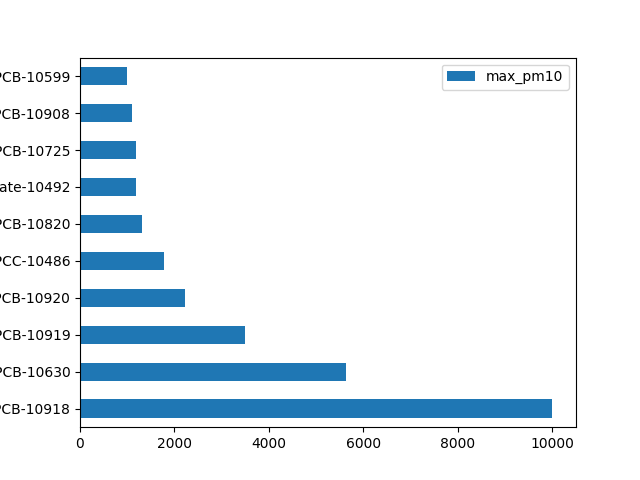

In [17]:
# On EMR we need this magic to show the plot
%matplot plt

# Zadanie 1

[1p.] Znajdź miasta, w których średnie stężenie pyłu “pm25” było niższe niż maksymalne stężenie w jednym wybranym mieście (w całym badanym okresie). Obliczenia wykonaj dla danych z kilku dni. Wyniki posortuj malejąco po stężeniu pm25.


In [18]:
smog_df = smog_df.withColumn('location_id', col('location_id').cast('int'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
from pyspark.sql.functions import avg
pm25 = smog_df.filter(col('parameter')=='pm25')\
            .filter(col('value')>0.0)\
            .select('location_id', 'location', 'value')\
            .groupby('location_id', 'location').agg(avg('value').alias('avg_pm25'), max('value').alias('max_pm25'))\
            .filter(col('avg_pm25') < col('max_pm25'))\
            .sort(asc('location_id'))
pm25.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------------+------------------+--------+
|location_id|            location|          avg_pm25|max_pm25|
+-----------+--------------------+------------------+--------+
|        100|Badhoevedorp-Slot...|             10.11|    37.5|
|        101|Amsterdam-Hoogtij...|10.352830188679244|    30.8|
|        102|Amsterdam-Einstei...| 8.272164948453607|    27.5|
|       1000|Presque Isle Rive...| 4.033942558746737|    16.0|
|       1003|        Padonia-1003| 4.916442048517521|    16.0|
|       1004|Padre Las Casas I...|101.72420634920636|   251.0|
|       1006|    Painesville-1006| 6.980962343096236|    21.1|
|       1010|   Preble NCore-1010| 7.384917355371901|    21.1|
|       1013|     Palo Verde-1013| 5.165459610027855|    35.6|
|       1018|    Parry Sound-1018| 5.181657848324515|    20.0|
|       1022|     Paul Meyer-1022| 6.183606557377048|    45.1|
|       1029|Pendleton - McKay...|2.3189723320158104|     6.3|
|       1031|    Pepsi Place-1031| 8.393318965517242|  

# Zadanie 2
[1p.] Dla danych z wybranych kilku dni przedstaw w ujęciu godzinowym (wybierz czas UTC) najwyższe zanotowane stężenie pm10 z całego zbioru danych wraz z nazwą miasta, gdzie to maksymalne stężenie nastąpiło . Wyniki posortuj po rosnąco datach.

In [20]:
smog_df = smog_df.withColumn('datetime', col('datetime').cast('timestamp'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
from pyspark.sql.functions import col, avg, date_format
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

avg_by_hour = smog_df.filter(col('datetime').between('2022-05-01', '2022-05-03'))\
    .filter(col('value')>0.0)\
    .filter(col('parameter')=='pm25')\
    .withColumn('date_hour', date_format(col('datetime'), 'yyyy-MM-dd HH')) \
    .groupby('date_hour', 'location') \
    .agg(avg('value').alias('avg_value'))\
    .sort('date_hour')

window_spec = Window.partitionBy('date_hour').orderBy(col('avg_value').desc())

top_locations = avg_by_hour.withColumn('rank', row_number().over(window_spec)) \
    .filter(col('rank') == 1) \
    .select('date_hour', 'location', 'avg_value') \
    .sort('date_hour')

top_locations.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+--------------------+---------+
|    date_hour|            location|avg_value|
+-------------+--------------------+---------+
|2022-05-01 00|Mini Secretariat,...|     97.3|
|2022-05-01 01|Mundka, Delhi - D...|    114.0|
|2022-05-01 02|Mini Secretariat,...|    115.1|
|2022-05-01 03|Mini Secretariat,...|    139.2|
|2022-05-01 04|Mini Secretariat,...|    150.8|
|2022-05-01 05|Mini Secretariat,...|    135.2|
|2022-05-01 06|Mini Secretariat,...|    128.7|
|2022-05-01 07|Mini Secretariat,...|    115.2|
|2022-05-01 08|Teri Gram, Gurugr...|    115.6|
|2022-05-01 09|Teri Gram, Gurugr...|    116.7|
|2022-05-01 10|Teri Gram, Gurugr...|    118.2|
|2022-05-01 11|Teri Gram, Gurugr...|    112.5|
|2022-05-01 12|Teri Gram, Gurugr...|    104.6|
|2022-05-01 13|Teri Gram, Gurugr...|     96.7|
|2022-05-01 14|Teri Gram, Gurugr...|     90.9|
|2022-05-01 15|Teri Gram, Gurugr...|     84.7|
|2022-05-01 16|Mundka, Delhi - D...|     84.0|
|2022-05-01 17|Industrial Area, ...|     82.0|
|2022-05-01 1

# Zadanie 3
[1p.] Znajdź ranking miast  pod względem średniego zanieczyszczenia liczonego dla N najwyższych pomiarów pod względem “pm25” dla danych z kilku dni. 

In [22]:
window_spec = Window.partitionBy('location').orderBy('datetime')

ranking = smog_df.filter(col('parameter') == 'pm25') \
    .filter(col('value') > 0.0) \
    .filter(col('datetime').between('2022-05-01', '2022-05-30')) \
    .withColumn('row_number', row_number().over(window_spec)) \
    .filter(col('row_number') <= 30) \
    .drop('row_number')

final_ranking = ranking.groupby('location') \
    .agg(avg('value').alias('avg_pm25')) \
    .sort(desc('avg_pm25'))

final_ranking.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|            location|          avg_pm25|
+--------------------+------------------+
|New Industrial To...|            171.84|
|Sector 11, Farida...|109.61333333333333|
|ITO, Delhi - CPCB...|103.53333333333333|
|Rohini, Delhi - D...|              84.9|
|Mini Secretariat,...| 82.55666666666664|
|Teri Gram, Gurugr...| 77.59666666666666|
|Sector-51, Gurugr...| 76.17966666666668|
|Narela, Delhi - D...|              73.5|
|Mundka, Delhi - D...|              69.8|
|Sri Aurobindo Mar...| 65.16666666666667|
|Rishi Nagar, Kait...|63.648999999999994|
|Civil Lines,  Ajm...| 63.31333333333335|
|Najafgarh, Delhi ...|              62.6|
|NISE Gwal Pahari,...| 56.45566666666668|
|Sector-12, Karnal...| 54.57133333333332|
|Govt. High School...|53.936666666666675|
|Industrial Area, ...|              53.7|
|Sanjay Nagar, Gha...| 53.43333333333333|
|Padre Las Casas I...| 51.06666666666667|
|Marhatal, Jabalpu...| 50.63333333333333|
+--------------------+------------

# Zadanie 4
[2p.] Zwizualizuj na mapie średnie zanieczyszczenie wybranych miast dla wybranych kilku dni względem czasu (mapa + slider czasu albo zbiór klatek i animacja) 

# Zadanie 5
[3p.] Korzystanie z klastra dla dużych danych
Proszę wykonać zadanie 1 dla danych o tak dobranym rozmiarze, żeby czas zapytania wynosił co najmniej 10 minut. Zmierzyć czas wykonania.
Zwiększyć klaster do 2, 3, 4, 5, 6, 7 instancji workerów i zmierzyć czasy wykonania.
Narysować wykresy czasu, przyspieszenia, efektywności (time, speedup, efficiency).

# Zadanie 6
[1p.] Dla przykładowego zapytania załącz wybrane wykresy ze Spark UI (https://spark.apache.org/docs/latest/web-ui.html), np. DAG, diagram Gantta, informacje o rozmiarach danych.


Schemat całego zadania:

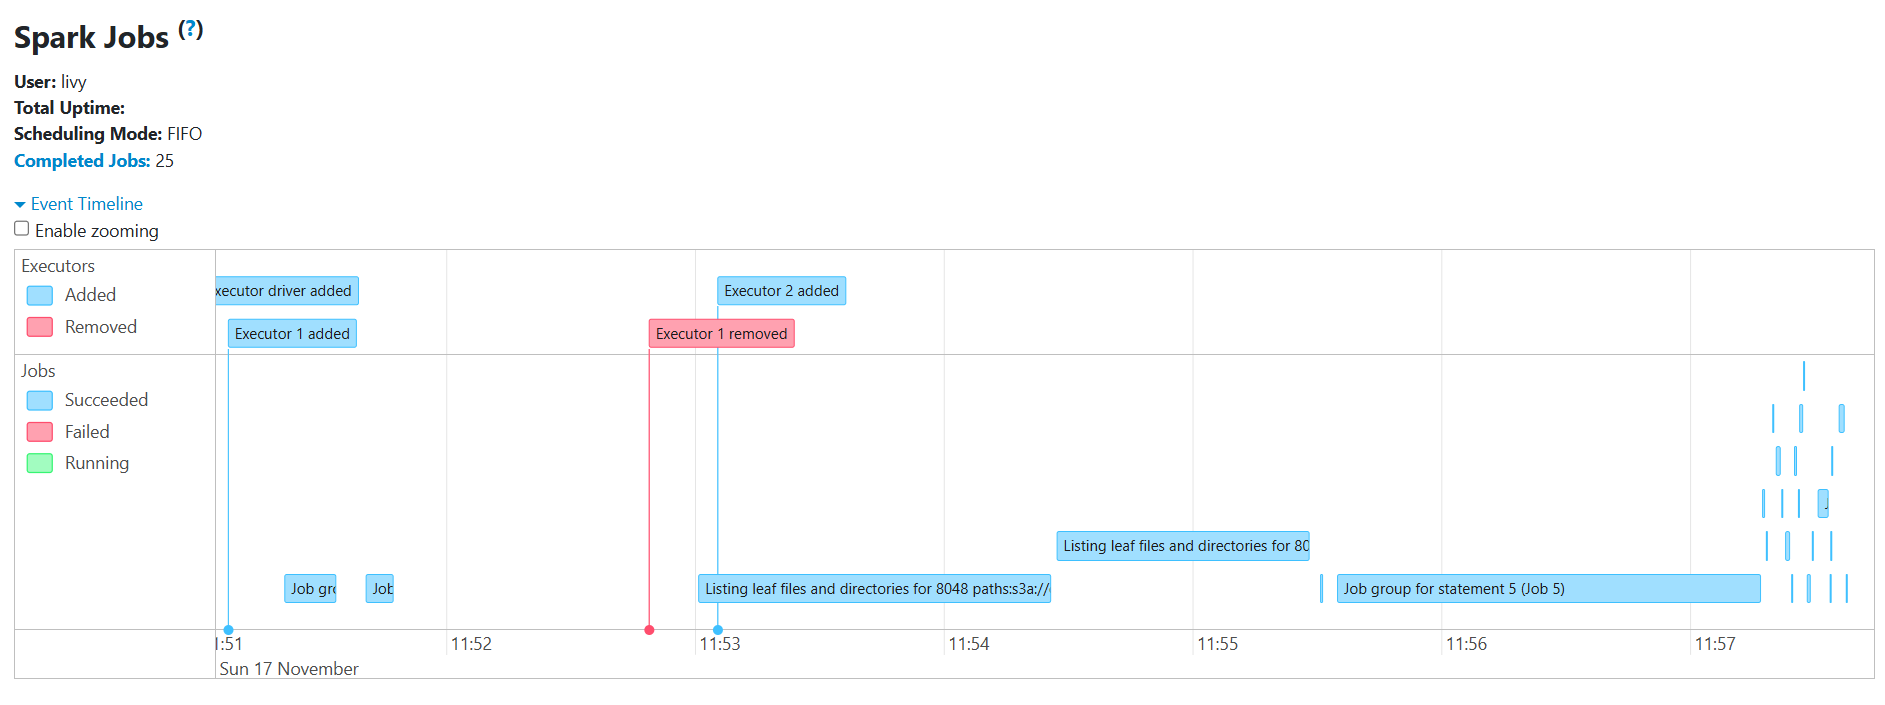

Wykres Gantta dla pierwszego zadania:

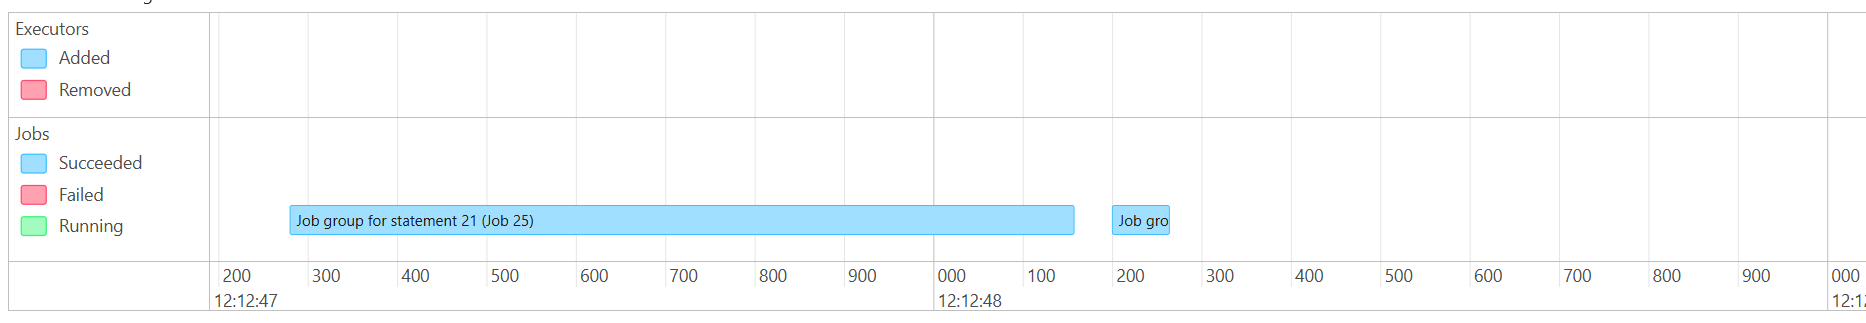

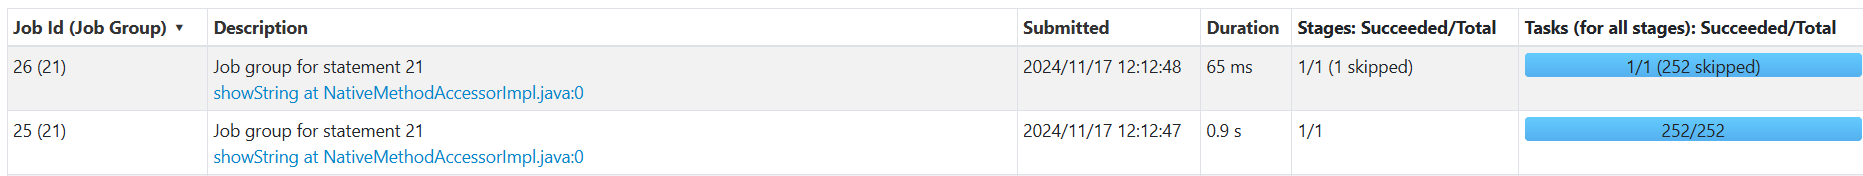

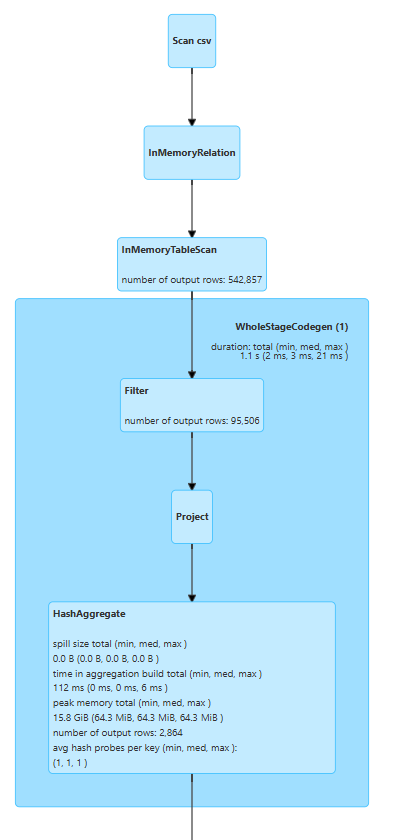

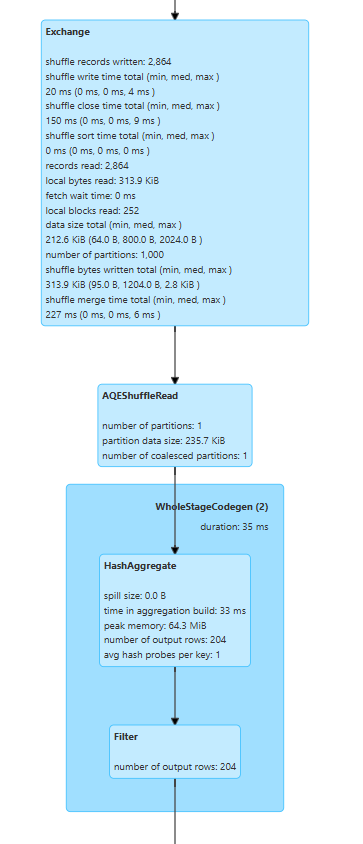

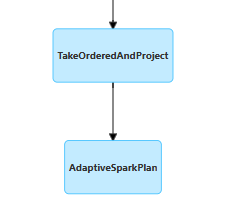